In [1]:
import matplotlib.pyplot as plt
import torch
import os
from collections import Counter
from torchvision import transforms
from dataset import ChessDataset, INDEX_TO_PIECE, labels_to_fen, parse_full_fen

/Users/echen314/miniconda3/envs/chess_vision/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load dataset without normalization so we can display raw images
TRAIN_DIR = "data/train"
MAX_SAMPLES = 500  # keep it fast for visualization

raw_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
dataset = ChessDataset(TRAIN_DIR, max_samples=MAX_SAMPLES, transform=raw_transform)
print(f"Dataset size: {len(dataset)}")
print(f"Manifest mode: {dataset.use_manifest}")
if dataset.use_manifest:
    sample = dataset.samples[0]
    print(f"Sample keys: {list(sample.keys())}")
    print(f"First sample: {sample}")

Dataset size: 500
Manifest mode: True
Sample keys: ['filename', 'fen', 'legal', 'turn', 'castling', 'en_passant', 'piece_count', 'has_highlight', 'style', 'flipped']
First sample: {'filename': '000000.png', 'fen': 'r2q1rk1/pbpp1ppp/5b2/2p5/2B1P3/2N2Q2/PPP2PPP/R3K2R w KQ -', 'legal': '1', 'turn': 'w', 'castling': 'KQ', 'en_passant': '-', 'piece_count': '26', 'has_highlight': '1', 'style': 'game_room', 'flipped': '0'}


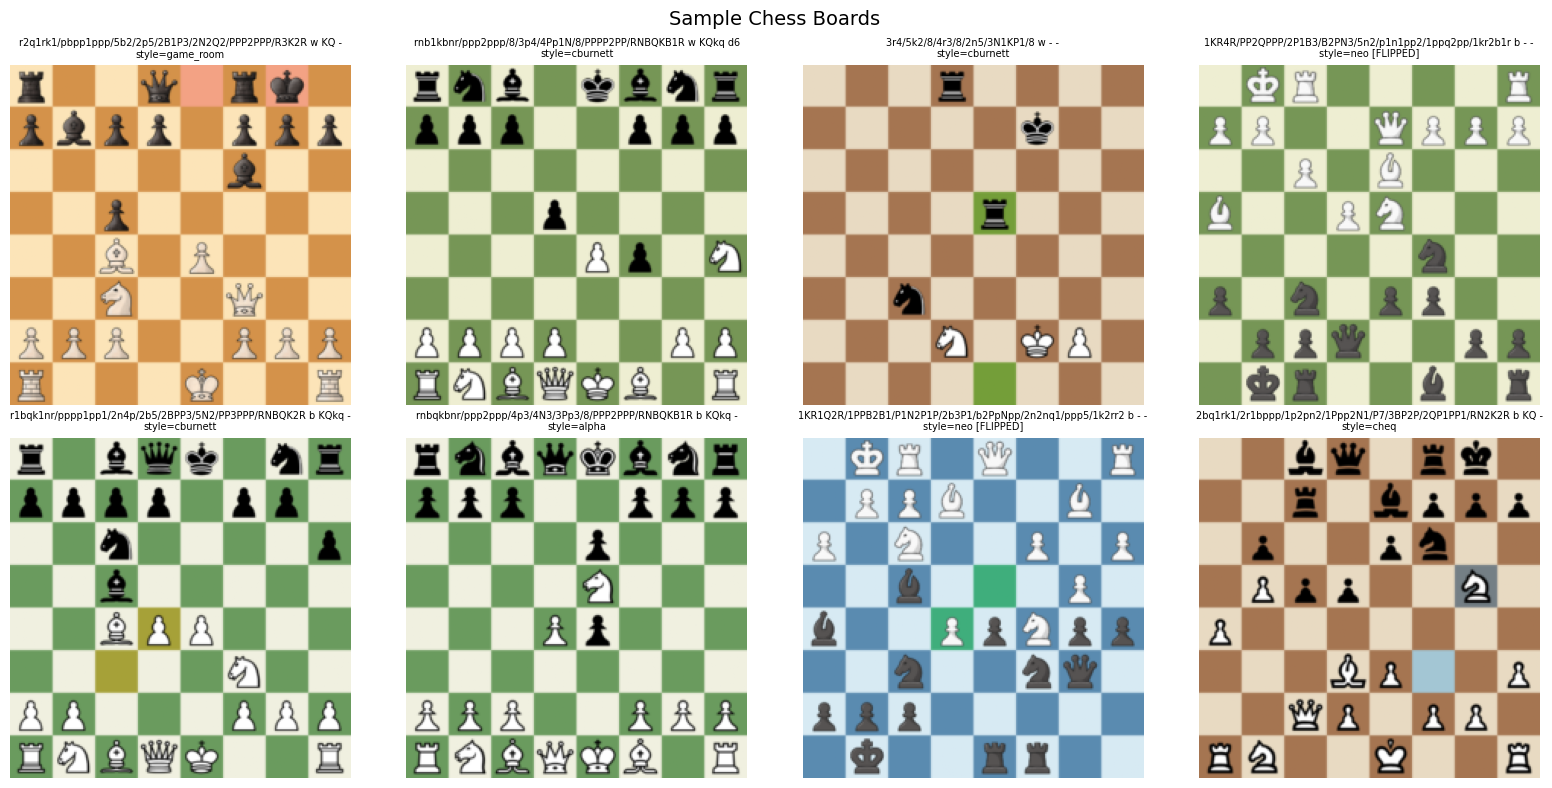

In [3]:
# Show a grid of sample boards with FEN, turn, and castling
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for i, ax in enumerate(axes.flat):
    image, labels = dataset[i]
    meta = dataset.get_metadata(i)
    fen = meta.get("fen", "?")
    style = meta.get("style", "?")
    flipped = meta.get("flipped", "0") == "1"

    ax.imshow(image.permute(1, 2, 0))
    title = f"{fen}\nstyle={style}"
    if flipped:
        title += " [FLIPPED]"
    ax.set_title(title, fontsize=7)
    ax.axis("off")
plt.suptitle("Sample Chess Boards", fontsize=14)
plt.tight_layout()
plt.show()

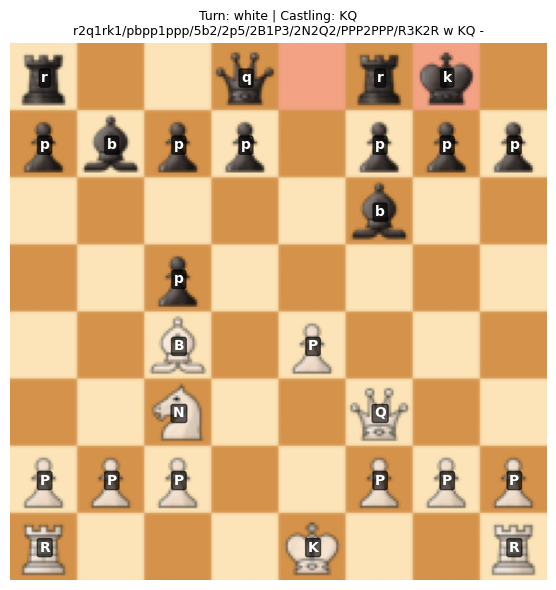

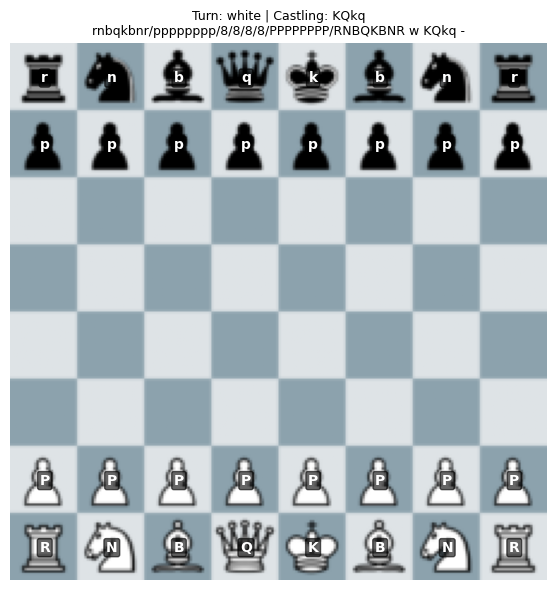

In [4]:
# Visualize one board with piece labels overlaid on each square
def show_board_with_labels(dataset, idx):
    image, labels = dataset[idx]
    meta = dataset.get_metadata(idx)
    fen = meta.get("fen", "?")

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(image.permute(1, 2, 0))

    sq_size = 224 / 8
    for sq in range(64):
        row, col = divmod(sq, 8)
        piece = INDEX_TO_PIECE[labels["squares"][sq].item()]
        if piece != '.':
            ax.text(
                col * sq_size + sq_size / 2,
                row * sq_size + sq_size / 2,
                piece,
                ha="center", va="center",
                fontsize=10, fontweight="bold",
                color="white",
                bbox=dict(boxstyle="round,pad=0.15", fc="black", alpha=0.6),
            )

    turn = "white" if labels["turn"].item() < 0.5 else "black"
    castling = []
    for flag, ch in zip(labels["castling"].tolist(), ["K", "Q", "k", "q"]):
        if flag > 0.5:
            castling.append(ch)
    castling_str = "".join(castling) or "-"

    ax.set_title(f"Turn: {turn} | Castling: {castling_str}\n{fen}", fontsize=9)
    ax.axis("off")
    plt.tight_layout()
    plt.show()

show_board_with_labels(dataset, 0)
show_board_with_labels(dataset, 42)

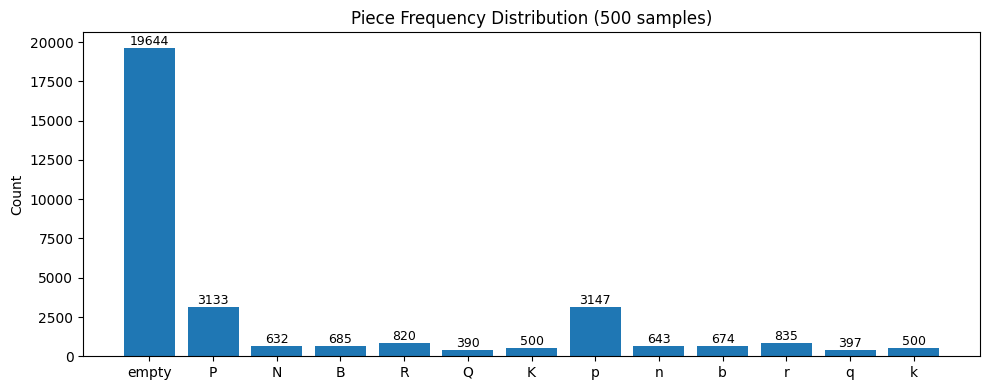

In [5]:
# Piece frequency distribution across the dataset
all_sq_labels = torch.stack([dataset[i][1]["squares"] for i in range(len(dataset))])  # (N, 64)
counts = torch.bincount(all_sq_labels.flatten(), minlength=13)

piece_names = [INDEX_TO_PIECE[i] for i in range(13)]
piece_names[0] = "empty"

fig, ax = plt.subplots(figsize=(10, 4))
bars = ax.bar(piece_names, counts.numpy())
ax.set_ylabel("Count")
ax.set_title(f"Piece Frequency Distribution ({len(dataset)} samples)")
for bar, count in zip(bars, counts):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
            str(count.item()), ha="center", va="bottom", fontsize=9)
plt.tight_layout()
plt.show()

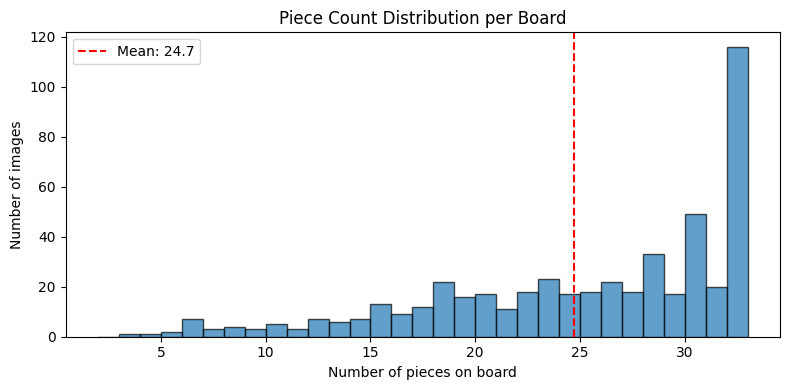

In [6]:
# Piece count per board — distribution across game phases
if dataset.use_manifest:
    piece_counts = [int(s.get("piece_count", 0)) for s in dataset.samples]
else:
    piece_counts = [(all_sq_labels[i] != 0).sum().item() for i in range(len(dataset))]

import numpy as np
piece_counts = np.array(piece_counts)

fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(piece_counts, bins=range(2, 34), edgecolor="black", alpha=0.7)
ax.set_xlabel("Number of pieces on board")
ax.set_ylabel("Number of images")
ax.set_title("Piece Count Distribution per Board")
ax.axvline(piece_counts.mean(), color="red", linestyle="--",
           label=f"Mean: {piece_counts.mean():.1f}")
ax.legend()
plt.tight_layout()
plt.show()

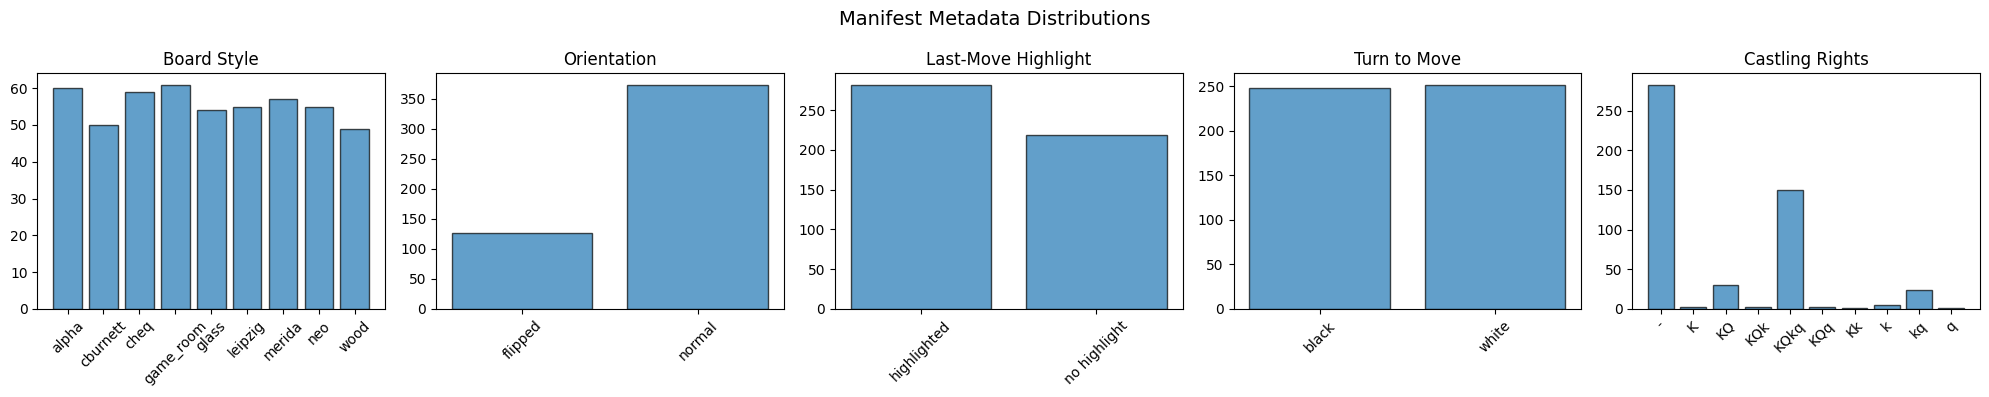

In [7]:
# Manifest metadata distributions (style, flipped, highlight, turn, castling)
if dataset.use_manifest:
    fields = {
        "style": "Board Style",
        "flipped": "Orientation",
        "has_highlight": "Last-Move Highlight",
        "turn": "Turn to Move",
        "castling": "Castling Rights",
    }
    label_maps = {
        "flipped": {"0": "normal", "1": "flipped"},
        "has_highlight": {"0": "no highlight", "1": "highlighted"},
        "turn": {"w": "white", "b": "black"},
    }

    fig, axes = plt.subplots(1, len(fields), figsize=(20, 4))
    for ax, (field, title) in zip(axes, fields.items()):
        values = [s.get(field, "?") for s in dataset.samples]
        lmap = label_maps.get(field, {})
        values = [lmap.get(v, v) for v in values]
        counts = Counter(values)
        keys = sorted(counts.keys())
        ax.bar(keys, [counts[k] for k in keys], edgecolor="black", alpha=0.7)
        ax.set_title(title)
        ax.tick_params(axis="x", rotation=45)
    plt.suptitle("Manifest Metadata Distributions", fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print("No manifest — metadata distributions not available.")

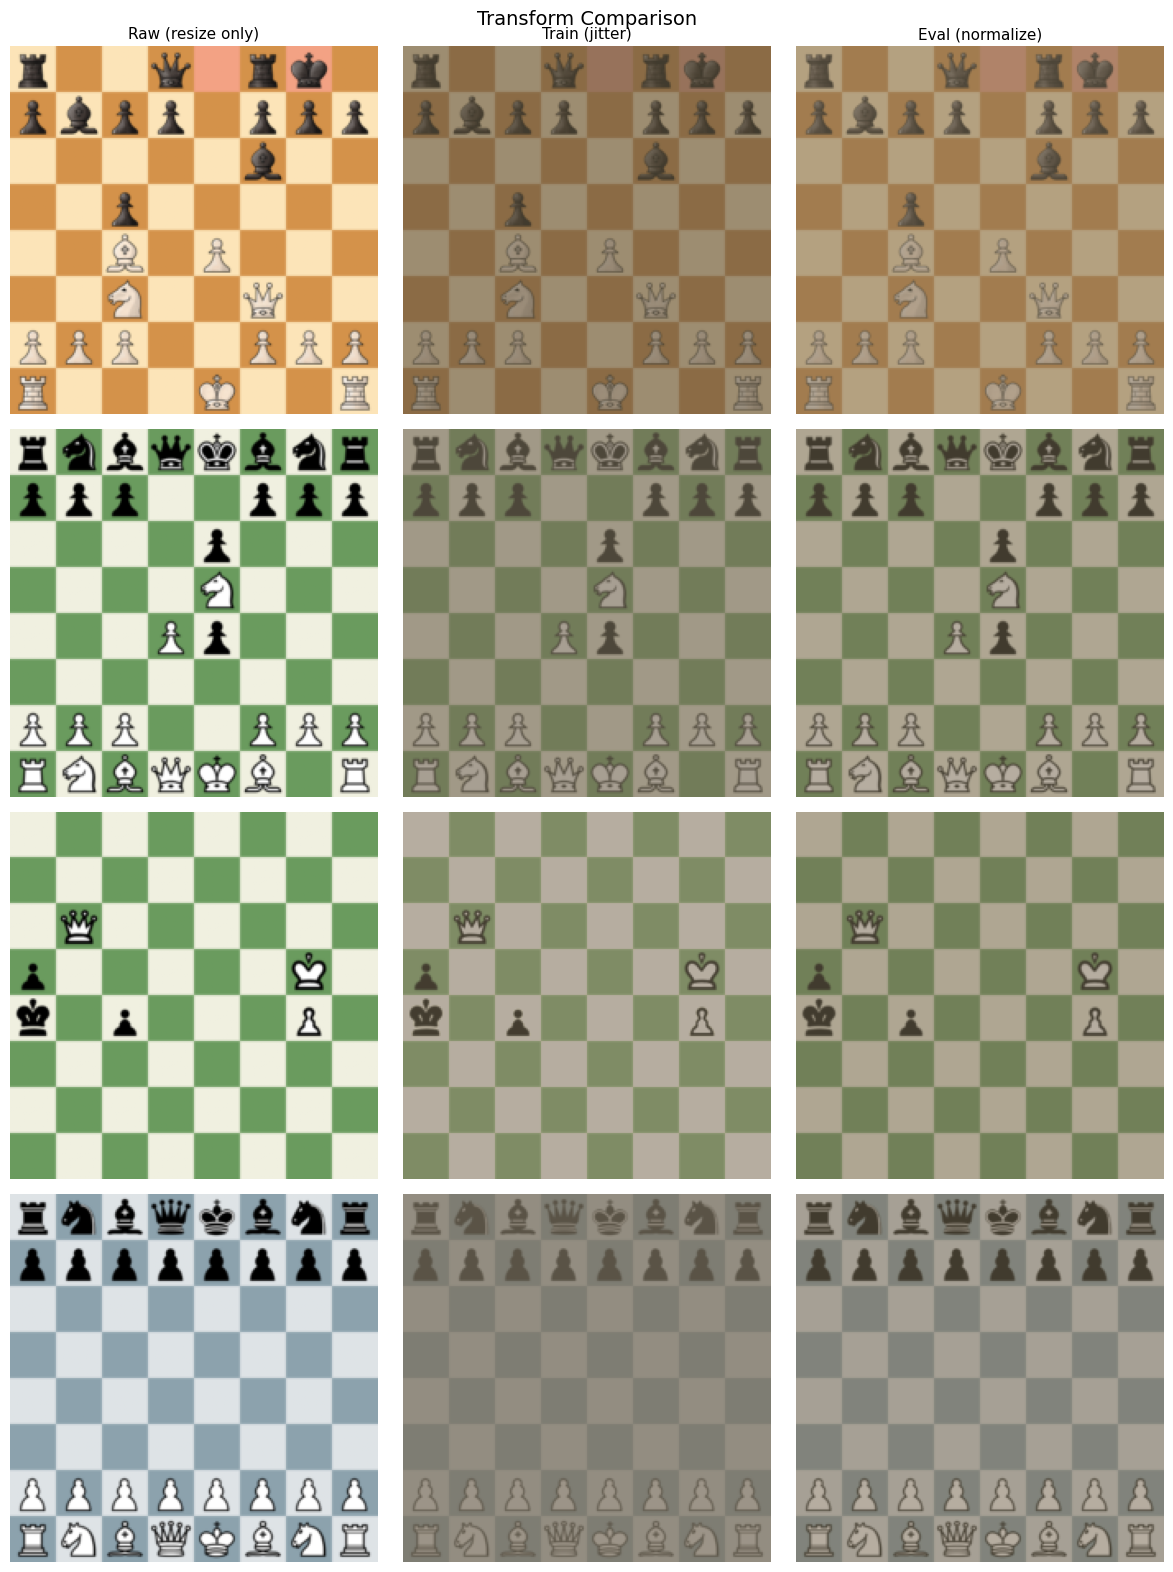

In [8]:
# Compare raw, train-augmented, and eval transforms side by side
from dataset import get_transform
from PIL import Image

train_t = get_transform("vit_base_patch16_224.augreg_in21k", is_training=True)
eval_t = get_transform("vit_base_patch16_224.augreg_in21k", is_training=False)

def unnormalize(img_tensor, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    """Undo ImageNet normalization for display."""
    img = img_tensor.clone()
    for c in range(3):
        img[c] = img[c] * std[c] + mean[c]
    return img.clamp(0, 1)

sample_indices = [0, 5, 20, 42]
fig, axes = plt.subplots(len(sample_indices), 3, figsize=(12, 4 * len(sample_indices)))

for row, idx in enumerate(sample_indices):
    filename = dataset.samples[idx]["filename"]
    img_path = os.path.join(TRAIN_DIR, filename)
    pil_img = Image.open(img_path).convert("RGB")

    raw_img = raw_transform(pil_img)
    train_img = unnormalize(train_t(pil_img))
    eval_img = unnormalize(eval_t(pil_img))

    for col, (title, tensor) in enumerate([
        ("Raw (resize only)", raw_img),
        ("Train (jitter)", train_img),
        ("Eval (normalize)", eval_img),
    ]):
        axes[row, col].imshow(tensor.permute(1, 2, 0).numpy())
        if row == 0:
            axes[row, col].set_title(title, fontsize=11)
        axes[row, col].axis("off")

    axes[row, 0].set_ylabel(f"#{idx}", fontsize=10, rotation=0, labelpad=30)

plt.suptitle("Transform Comparison", fontsize=14)
plt.tight_layout()
plt.show()